<a href="https://colab.research.google.com/github/rajkgoel/AW-Internet-Sales1/blob/master/Ecomm_Case_Study1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# Global data that are used across the case-study solutions
import pandas as pd

# Read all the data from the drive
url = "https://drive.google.com/uc?"

customer_data_df = pd.read_excel(f"{url}id=1rqihT647UW9HEmERxCrTJrcZZ9xE5TEi")
discount_coupon_df = pd.read_csv(f"{url}id=1CfORUKckP7Qi9swmCe8XEgLLWnpKl4eE")
marketing_spend_df = pd.read_csv(f"{url}id=1hjHgCluvPEUfrp9w-_-73ch0d9SK6FHf")
online_sales_df = pd.read_csv(f"{url}id=1ZvQn7-UtGSdJa3H9zM4ve_uzACFAzF0Z")
tax_amount_df = pd.read_excel(f"{url}id=1tqJmtKcfhiEJXYVV21ybnD4UaXYW9r4v")

month_map = { 1: "January", 2: "February", 3: "March", 4: "April", 5: "May", 6: "June", 7: "July",
             8: "August", 9: "September", 10: "October", 11: "November", 12: "December" }

# Convert Transaction Date
online_sales_df["Transaction_Date"] = pd.to_datetime(online_sales_df["Transaction_Date"], format="%m/%d/%Y")


In [3]:
#1. Identify the months with the highest and lowest customer acquisition count.
#   What strategies could be implemented to address the fluctuations and ensure consistent growth throughout the year?

# Find Earliest Transaction Date for each customer
earliest_txn = (online_sales_df.groupby("CustomerID")["Transaction_Date"].min().reset_index(name="Earliest_Transaction_Date"))

# Convert dates to months
earliest_txn["Transaction_Month"] = earliest_txn["Earliest_Transaction_Date"].dt.month
monthly_acquisitions = earliest_txn.groupby("Transaction_Month")["CustomerID"].count().reset_index(name="Acquisitions")
monthly_acquisitions["Month"] = monthly_acquisitions["Transaction_Month"].map(month_map)

# Months with Highest & Lowest Acquisitions
highest = monthly_acquisitions[monthly_acquisitions['Acquisitions'] == monthly_acquisitions['Acquisitions'].max()]
highest_month = highest["Month"].iloc[0]
lowest = monthly_acquisitions[monthly_acquisitions['Acquisitions'] == monthly_acquisitions['Acquisitions'].min()]
lowest_month = lowest['Month'].iloc[0]

# Next 2 months with lowest acquisitions
next_2 = monthly_acquisitions.sort_values(by='Acquisitions', ascending=True).iloc[1:3][['Month']]

print(f"""*********
{highest_month} records the highest number of customer acquisitions, while {lowest_month} has the lowest acquisition levels, highlighting an opportunity for improvement.

To boost customer acquisition in {lowest_month}, targeted strategies such as additional discounts or promotional coupons can be introduced.

Similar incentive-based campaigns may also be effective in {next_2['Month'].iloc[0]} and {next_2['Month'].iloc[1]}, which are the next two lowest-performing months in terms of acquisitions.
********* """)

********* 
January records the highest number of customer acquisitions, while November has the lowest acquisition levels, highlighting an opportunity for improvement.

To boost customer acquisition in November, targeted strategies such as additional discounts or promotional coupons can be introduced.

Similar incentive-based campaigns may also be effective in September and October, which are the next two lowest-performing months in terms of acquisitions.
********* 


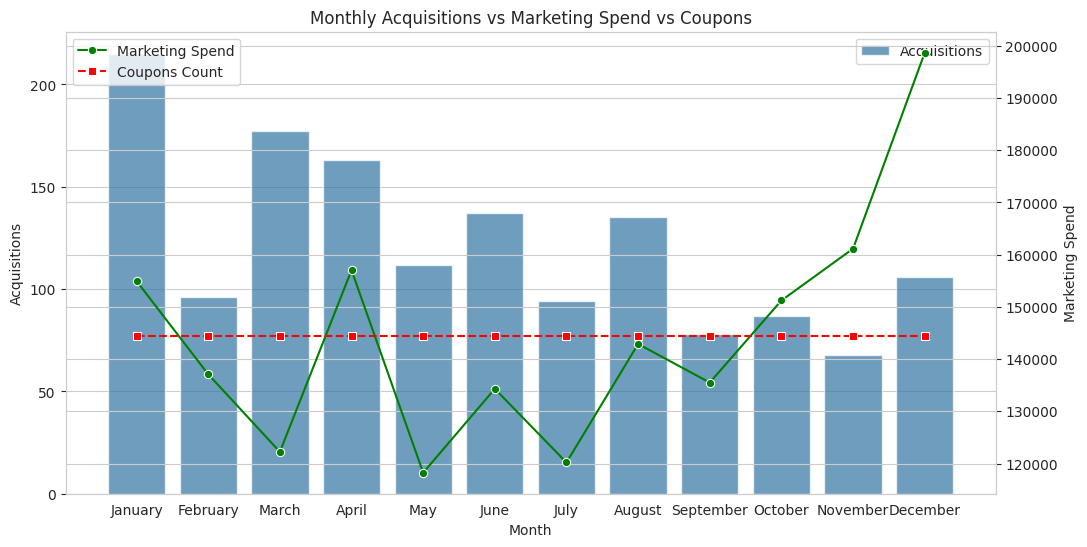


The chart indicates that coupon availability remains consistent throughout the year, while customer acquisition closely follows marketing spend patterns. 
This suggests that marketing expenditure has a greater influence on acquisition than coupons alone. Increasing or optimizing marketing spend during key periods 
may help maintain more stable and predictable customer acquisition levels.


In [4]:
# 2. Analyze the data to determine if certain months consistently show higher or lower acquisition.
# How can the company capitalize on high-performing months and improve performance during slower periods?
# Hint: Building on your analysis from Question 1, look for recurring patterns or anomalies in monthly acquisition count.
# Hint: Consider how to leverage insights from high-performing months (e.g., specific marketing efforts, product launches)
# and what targeted interventions might stimulate demand during slower periods.

import matplotlib.pyplot as plt

# Coupons
monthwise_coupons = discount_coupon_df.groupby("Month")["Coupon_Code"].count().reset_index(name="Coupons_Count")
monthwise_coupons["Month"] = pd.to_datetime(monthwise_coupons["Month"], format="%b").dt.strftime("%B")

# Marketting Spend
marketing_spend_df["Date"] = pd.to_datetime(marketing_spend_df["Date"], format="%m/%d/%Y")
marketing_spend_df["Month"] = marketing_spend_df["Date"].dt.month.map(month_map)
monthly_marketing_df = (marketing_spend_df.groupby("Month", as_index=False)[["Offline_Spend", "Online_Spend"]].sum())
monthly_marketing_df["Total"] = monthly_marketing_df["Offline_Spend"] + monthly_marketing_df["Online_Spend"]
monthly_marketing_df = monthly_marketing_df.sort_values("Month")

# Merge the data
merged_df = monthly_acquisitions.merge(monthly_marketing_df, on="Month", how="inner")
merged_df = merged_df.merge(monthwise_coupons, on="Month", how="inner")

# Plot the Chart
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

fig, ax1 = plt.subplots(figsize=(12, 6))

# BAR: Monthly Acquisitions
sns.barplot(x="Month", y="Acquisitions", data=merged_df, ax=ax1, alpha=0.7, label="Acquisitions")
ax1.set_ylabel("Acquisitions")
ax1.set_xlabel("Month")

# LINE 1: Marketing Spend
ax2 = ax1.twinx()
sns.lineplot(x="Month", y="Total", data=merged_df, ax=ax2, color="green", marker="o", label="Marketing Spend")
ax2.set_ylabel("Marketing Spend")

# LINE 2: Coupons Count (scaled)
scale_factor = merged_df["Total"].mean() / merged_df["Coupons_Count"].mean()
sns.lineplot(x="Month", y=merged_df["Coupons_Count"] * scale_factor, data=merged_df, ax=ax2, color="red", linestyle="--", marker="s", label="Coupons Count")

plt.title("Monthly Acquisitions vs Marketing Spend vs Coupons")
plt.show()

print("""
The chart indicates that coupon availability remains consistent throughout the year, while customer acquisition closely follows marketing spend patterns.
This suggests that marketing expenditure has a greater influence on acquisition than coupons alone. Increasing or optimizing marketing spend during key periods
may help maintain more stable and predictable customer acquisition levels.""")


In [7]:
# 3. Identify periods with the strongest and weakest retention rates. What strategies could be implemented to improve retention during weaker months?
#     Hint: Retention isn’t just about who appeared again — it's about how many of this month's customers returned the next month,
#           as a percentage of the original month's customers. Think about comparing each month’s customer list to the next month’s,
#           and calculate what fraction was retained.
#           Monthly Retention rate = (Customers in Month X who returned in Month X+1) /  (total number of customers in month X)
#     Hint: For periods with weaker retention, consider what might lead to customer churn and what proactive measures could re-engage them.


online_sales_df["YearMonth"] = online_sales_df["Transaction_Date"].dt.to_period("M")

monthly_customers = (online_sales_df.groupby("YearMonth")["CustomerID"].apply(set).sort_index())
retention_data = []

months = monthly_customers.index.tolist()

for i in range(len(months) - 1):
    month_x = months[i]
    month_next = months[i + 1]

    customers_x = monthly_customers[month_x]
    customers_next = monthly_customers[month_next]

    retained_customers = customers_x.intersection(customers_next)

    retention_rate = (
        len(retained_customers) / len(customers_x)
        if len(customers_x) > 0 else 0
    )
    retention = {
        "Month": str(month_x),
        "Next_Month": str(month_next),
        "Customers_Month_X": len(customers_x),
        "Retained_Customers": len(retained_customers),
        "Retention_Rate": round(retention_rate, 3)
    }
    print(retention)
    retention_data.append(retention)



,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,YearMonth
0,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.50,Used,2019-01
1,17850,16680,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.50,Used,2019-01
2,17850,16681,2019-01-01,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Office,1,2.05,6.50,Used,2019-01
3,17850,16682,2019-01-01,GGOEGAAB010516,Google Men's 100% Cotton Short Sleeve Hero Tee...,Apparel,5,17.53,6.50,Not Used,2019-01
4,17850,16682,2019-01-01,GGOEGBJL013999,Google Canvas Tote Natural/Navy,Bags,1,16.50,6.50,Used,2019-01
...,...,...,...,...,...,...,...,...,...,...,...
52919,14410,48493,2019-12-31,GGOENEBB078899,Nest Cam Indoor Security Camera - USA,Nest-USA,1,121.30,6.50,Clicked,2019-12
52920,14410,48494,2019-12-31,GGOEGAEB091117,Google Zip Hoodie Black,Apparel,1,48.92,6.50,Used,2019-12
52921,14410,48495,2019-12-31,GGOENEBQ084699,Nest Learning Thermostat 3rd Gen-USA - White,Nest-USA,1,151.88,6.50,Used,2019-12
52922,14600,48496,2019-12-31,GGOENEBQ079199,Nest Protect Smoke + CO White Wired Alarm-USA,Nest-USA,5,80.52,6.50,Clicked,2019-12
